In [256]:
import statsmodels.api as sm
from pmdarima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import timeseriesmetrics as tss

import timeseriesmetrics as mt

warnings.filterwarnings('ignore')

# DEFININDO O NOSSO PATH COM OS DADOS
DATA_PATH_TSLA = '../bds/TSLA.csv'


In [257]:
TESLA = pd.read_csv(DATA_PATH_TSLA ,sep=',',usecols=[0,4])

significantLags: [1, 5, 8, 10]


,Date,Close,(Close-1),(Close-5),(Close-8),(Close-10)
10,2020-09-16,147.253326,149.919998,122.093330,135.666672,158.350006
11,2020-09-17,141.143326,147.253326,123.779999,139.440002,149.123337


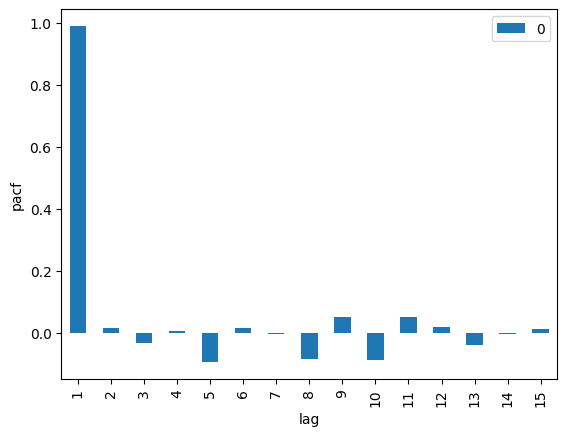

In [258]:
def getSignificantLags(y, nLags = 5, alpha=0.05):
    pac, pac_ci = sm.tsa.pacf(x=y, nlags=nLags, alpha=alpha)
    pd.DataFrame(pac)[1:].plot(kind='bar', legend='pacf',
                               xlabel='lag', ylabel='pacf');
    significantLags = []
    for i in range(1, len(pac)):
        # print(pac[i], pac_ci[i][0], pac_ci[i][1])
        if pac[i] < pac_ci[i][0] - pac[i] or pac[i] > pac_ci[i][1] - pac[i]:
            significantLags.append(i)
    print('significantLags:', significantLags)
    return significantLags

def appendLagVariables(yNm, significantLags, df, dropna=True):
    prefix = yNm.replace(')', '')
    df = df.copy()
    for lag in significantLags:
        varNm = '('+prefix+'-'+str(lag)+')'
        # nDj = pd.concat([nDj, nDj[['e1(t)']].shift(lag)], axis=1)
        df[varNm] = df[yNm].shift(lag)
        # nDj.columns = nDj.columns + [varNm]
    if dropna:
        df.dropna(axis=0, inplace=True)
    display(df.head(2))
    return df

e1_significantLags = getSignificantLags(y=TESLA['Close'], nLags = 15, alpha=0.05)
TM_tesla = appendLagVariables(yNm='Close', 
                         significantLags = e1_significantLags, 
                         df = TESLA, 
                         dropna=True)

In [259]:

df = TM_tesla.dropna()

# Separar features e target
X = df.drop('Close', axis=1)
X = X.drop('Date', axis=1)
y = df['Close']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [260]:
def calcular_metricas_regressao(y_true, y_pred):
    # Certifique-se de que y_true e y_pred são arrays de uma única dimensão
    y_true = np.array(y_true).flatten()  
    y_pred = np.array(y_pred).flatten()
    
    # Calcula as métricas
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)  # Raiz do MSE
    mape = tss.mape(y_true, y_pred)
    theil = tss.theil(y_true, y_pred)
    arv = tss.arv(y_true, y_pred)
    wpocid = tss.wpocid(y_true, y_pred)
    
    # Verifica se há mais de um ponto para calcular o R²
    if len(y_true) > 1:
        r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))  # Coeficiente de determinação
    else:
        r2 = 'N/A'  # Não aplicável para previsões de um único ponto
    
    # Cria um DataFrame com as métricas
    metrics_df = pd.DataFrame({
        'Métrica': ['MAE', 'MSE', 'MAPE','RMSE', 'R²','THEIL','ARV','WPOCID'],
        'Valor': [mae, mse, mape, rmse, r2, theil, arv, wpocid]
    })
    
    return metrics_df

In [261]:
from sklearn.preprocessing import StandardScaler

x_scale = StandardScaler()
y_scale = StandardScaler()

X_train_scaled = x_scale.fit_transform(X_train)
X_test_scaled = x_scale.fit_transform(X_test)

y_train_scaled = y_scale.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scale.fit_transform(y_test.values.reshape(-1, 1))

In [262]:
from sklearn.gaussian_process.kernels import RBF

In [263]:
class KRLS:
    def __init__(self, kernel_type='rbf', sigma=1.0, c=1.0, nu=1e-6):
        """
        Inicializa o modelo KRLS.
        
        :param kernel_type: Tipo de kernel a ser utilizado ('rbf' ou 'linear')
        :param sigma: Parâmetro do kernel RBF
        :param c: Parâmetro de regularização
        :param nu: Critério de crescimento
        """
        self.kernel_type = kernel_type  # Tipo de kernel ('rbf' ou 'linear')
        self.sigma = sigma  # Parâmetro do kernel RBF
        self.c = c          # Parâmetro de regularização
        self.nu = nu        # Critério de crescimento
        self.D = []         # Dicionário de vetores de suporte
        self.alpha = []     # Coeficientes de expansão
        self.K_inv = None   # Inversa da matriz de kernel regularizada
    def __rbf_kernel(self, x1, x2):
        """
        Calcula o kernel RBF entre dois vetores (função privada).
        """
        return np.exp(-np.linalg.norm(x1 - x2) ** 2 / (2 * self.sigma ** 2))
    
    def __linear_kernel(self, x1, x2):
        """
        Calcula o kernel linear entre dois vetores (função privada).
        """
        return x1@x2
    
    def __kernel(self, x1, x2):
        """
        Escolhe o kernel de acordo com o tipo especificado ('rbf' ou 'linear').
        """
        if self.kernel_type == 'rbf':
            return self.__rbf_kernel(x1, x2)
        elif self.kernel_type == 'linear':
            return self.__linear_kernel(x1, x2)
        else:
            raise ValueError("Tipo de kernel não suportado. Escolha 'rbf' ou 'linear'.")

    def predict(self, x):
        """
        Prediz o valor da saída para uma nova amostra x, usando o dicionário atual e os coeficientes.
        """
        if not self.D:  # Se o dicionário estiver vazio
            return 0
        
        k_n = np.array([self.__kernel(x, u) for u in self.D])
        #return np.dot(k_n.T, self.alpha)  # Retorna um escalar
        return k_n.T@self.alpha

    def __compute_an(self, k_n):
        """
        Calcula o vetor intermediário a_n (função privada).
        """
        #return np.dot(self.K_inv, k_n)
        return self.K_inv@k_n

    def __compute_gamma_n(self, k_nn, k_n, a_n):
        """
        Calcula o valor escalar gamma_n (função privada).
        """
        #return k_nn + self.c - np.dot(k_n.T, a_n)
        return k_nn + self.c - k_n.T@a_n

    def __update_kernel_inverse(self, a_n, gamma_n):
        """
        Atualiza a inversa da matriz de kernel quando o dicionário é expandido (função privada).
        """
        K_inv_old = self.K_inv
        K_inv_new = np.zeros((len(self.D), len(self.D)))
        if K_inv_old is not None:
            K_inv_new[:-1, :-1] = K_inv_old + np.outer(a_n, a_n) / gamma_n
            K_inv_new[:-1, -1] = -a_n / gamma_n
            K_inv_new[-1, :-1] = -a_n / gamma_n # MODIFIQUEI AQUI ANTES ERA TRANSPOSTO
            K_inv_new[-1, -1] = 1 / gamma_n
        else:
            K_inv_new[0, 0] = 1 / (self.__kernel(self.D[0], self.D[0]) + self.c)
        return K_inv_new

    def __update_alpha(self, e_n, gamma_n, a_n):
        """
        Atualiza os coeficientes de expansão alpha (função privada).
        """
        self.alpha = np.append(self.alpha, 0)
        self.alpha += (e_n / gamma_n) * np.append(-a_n, 1)

    def learn_one(self, x_n, y_n):
        """
        Atualiza o modelo KRLS com a nova amostra (x_n, y_n).
        """
        if not self.D:
            # Inicializa o dicionário e a matriz K_inv
            self.D.append(x_n)
            self.K_inv = np.array([[0]])  # Inicializa K_inv com um valor numérico
            self.alpha = np.array([0])  # Inicializa alpha com um valor numérico
            self.alpha = self.alpha.astype(np.float64)
            return

        # Predição
        y_hat = self.predict(x_n)

        # Cálculo do erro
        e_n = y_n - y_hat

        # Vetor de kernel k_n
        k_n = np.array([self.__kernel(x_n, u) for u in self.D])

        # Similaridade com o próprio ponto
        k_nn = self.__kernel(x_n, x_n)

        # Cálculo de a_n
        a_n = self.__compute_an(k_n)

        # Cálculo de gamma_n
        gamma_n = self.__compute_gamma_n(k_nn, k_n, a_n)

        # Critério de crescimento do dicionário
        if np.all(gamma_n > self.nu):
            # Expandir o dicionário
            self.D.append(x_n)

            # Atualizar a matriz inversa de kernel
            self.K_inv = self.__update_kernel_inverse(a_n, gamma_n)

            # Atualizar os coeficientes de expansão alpha
            self.__update_alpha(e_n, gamma_n, a_n)
        else:
            # Atualizar o dicionário sem expansão
            self.alpha += (e_n / gamma_n) * a_n

In [284]:
model = KRLS(kernel_type='rbf', sigma=1, c=0.8, nu=0.1)


In [285]:
for i in range(len(X_train_scaled)):
    model.learn_one(X_train_scaled[i][0], y_train_scaled[i][0])

In [286]:
previsoes = []

for i in range(len(X_test_scaled)):
    y_pred = model.predict(X_test_scaled[i])
    previsoes.append(y_pred)
    model.learn_one(y_pred, y_test_scaled[i][0])

In [287]:
previsoes = y_scale.inverse_transform(np.array([previsoes]))

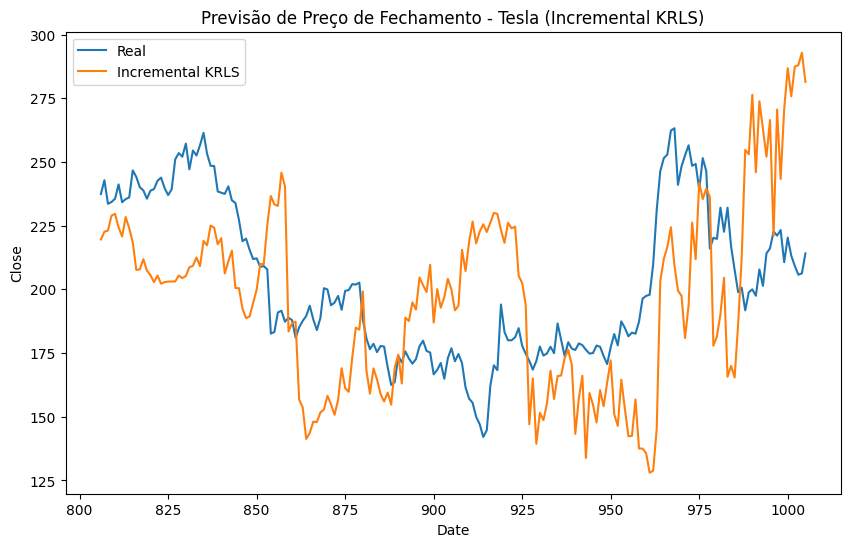

In [288]:
plt.figure(figsize=(10, 6))
plt.plot(X_test.index, y_test, label='Real')
plt.plot(X_test.index, previsoes[0], label='Incremental KRLS')
plt.title('Previsão de Preço de Fechamento - Tesla (Incremental KRLS)')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()


# ÁREA DE TESTES

pip install rpy2

PRECISA DO R INSTALADO NO COMPUTADOR

In [289]:
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro

In [290]:
numpy2ri.activate()

In [291]:
X_train_scaled_type_r = numpy2ri.numpy2rpy(X_train_scaled)
y_train_scaled_type_r = robjects.FloatVector(y_train_scaled)

In [292]:
KRLS_R = importr('KRLS')


In [ ]:
model = KRLS_R.krls(X=X_train_scaled_type_r, y=y_train_scaled_type_r)


In [274]:
summary = r.summary(model)

# Exibir o resultado
print(summary)

* *********************** *
Model Summary:

R2: 0.9748149 

Average Marginal Effects:
           Est Std. Error   t value      Pr(>|t|)
x1  0.90019933 0.01795098 50.147643 5.273246e-248
x2  0.06207261 0.02486646  2.496239  1.275406e-02
x3  0.03076714 0.02693007  1.142483  2.535986e-01
x4 -0.07459505 0.02241205 -3.328346  9.139768e-04

Quartiles of Marginal Effects:
            25%         50%         75%
x1  0.854733792  0.95632965  0.99533921
x2  0.025485241  0.04931312  0.10148424
x3  0.008897211  0.05945357  0.07837647
x4 -0.105525650 -0.08740869 -0.04502811
$coefficients
           Est Std. Error   t value      Pr(>|t|)
x1  0.90019933 0.01795098 50.147643 5.273246e-248
x2  0.06207261 0.02486646  2.496239  1.275406e-02
x3  0.03076714 0.02693007  1.142483  2.535986e-01
x4 -0.07459505 0.02241205 -3.328346  9.139768e-04

$qcoefficients
            25%         50%         75%
x1  0.854733792  0.95632965  0.99533921
x2  0.025485241  0.04931312  0.10148424
x3  0.008897211  0.05945357  0.0

In [275]:
X_test_scaled_type_r = numpy2ri.numpy2rpy(X_test_scaled)
y_test_scaled_type_r = robjects.FloatVector(y_test_scaled)

In [276]:
previsoes = KRLS_R.predict_krls(model, newdata = X_test_scaled)

In [277]:
pandas_previsoes = pandas2ri.rpy2py(previsoes)

In [278]:
previsoes = KRLS_R.predict_krls(model, newdata = X_test_scaled)

In [279]:
# Supondo que você já tenha seu objeto 'previsoes'
fit_matrix = previsoes.rx2('fit')  # Extrai o slot 'fit'

# Converter a matriz numpy para um DataFrame do Pandas
pandas_previsoes_df = pd.DataFrame(fit_matrix, columns=['Previsões'])

# Exibir o DataFrame do Pandas
print(pandas_previsoes_df)

     Previsões
0     0.700914
1     1.143594
2     1.226615
3     0.997042
4     1.062257
..         ...
195   0.552120
196   0.343268
197   0.226343
198   0.080899
199   0.098630

[200 rows x 1 columns]


In [280]:
previsoes = y_scale.inverse_transform(pandas_previsoes_df)

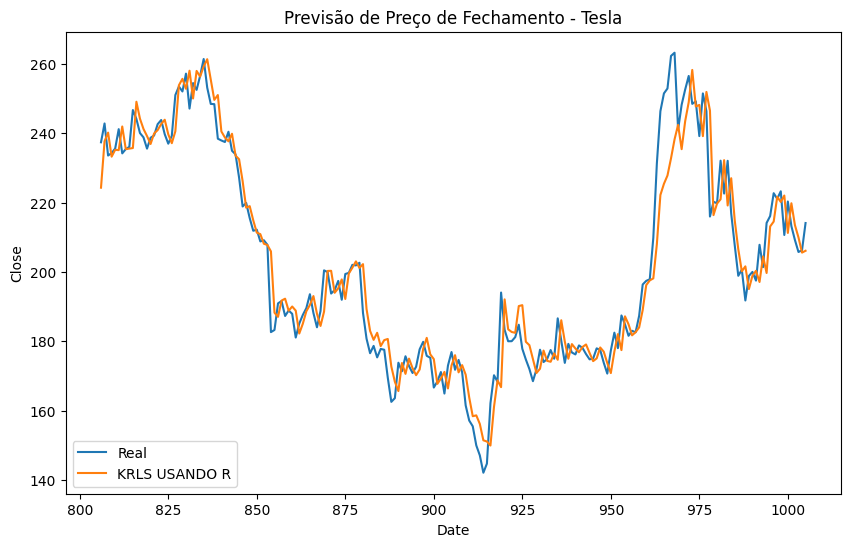

In [281]:
plt.figure(figsize=(10, 6))
plt.plot(X_test.index, y_test, label='Real')
plt.plot(X_test.index, previsoes, label='KRLS USANDO R')
plt.title('Previsão de Preço de Fechamento - Tesla')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()


In [282]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import timeseriesmetrics as tss

def calcular_metricas_regressao(y_true, y_pred):
    # Certifique-se de que y_true e y_pred são arrays de uma única dimensão
    y_true = np.array(y_true).flatten()  
    y_pred = np.array(y_pred).flatten()
    
    # Calcula as métricas
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)  # Raiz do MSE
    mape = tss.mape(y_true, y_pred)
    theil = tss.theil(y_true, y_pred)
    arv = tss.arv(y_true, y_pred)
    wpocid = tss.wpocid(y_true, y_pred)
    
    # Verifica se há mais de um ponto para calcular o R²
    if len(y_true) > 1:
        r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))  # Coeficiente de determinação
    else:
        r2 = 'N/A'  # Não aplicável para previsões de um único ponto
    
    # Cria um DataFrame com as métricas
    metrics_df = pd.DataFrame({
        'Métrica': ['MAE', 'MSE', 'MAPE','RMSE', 'R²','THEIL','ARV','WPOCID'],
        'Valor': [mae, mse, mape, rmse, r2, theil, arv, wpocid]
    })
    
    return metrics_df

In [283]:
calcular_metricas_regressao(y_test, previsoes)

,Métrica,Valor
0,MAE,5.671387
1,MSE,64.728839
2,MAPE,2.782450
3,RMSE,8.045423
4,R²,0.929173
5,THEIL,1.313550
6,ARV,0.070827
7,WPOCID,0.557789
